# DeepCluster

Выполнила: Кривуля Полина

DeepCluster - это метод самообучения, предложенный Facebook AI Research.

DeepCluster объединяет в себе две части: неконтролируемую кластеризацию и глубокие нейронные сети.  Объекты генерируются и группируются итеративно, чтобы получить как обученную модель, так и метки на выходе.

В DeepCluster на вход поступают неразмеченные данные. В данной работе рассматривается датасет изображений цифр MNIST. Затем в качестве средства извлечения признаков используется архитектура сверточной нейронной сети. Первоначально сеть инициализируется со случайными весами. В оригинальной статье используется используется PCA для уменьшения размерности вектора признаков. В данной работе это не применяется, так как в рассматриваемом датасете всего 64 признака. Наконец, обработанные объекты передаются в K-means для получения (псевдо) назначения кластера для каждого изображения.

Эти назначения кластеров используются в качестве псевдометок, и сеть обучается прогнозировать эти кластеры. Для оценки производительности модели используется потеря перекрестной энтропии. 

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import torch.utils.data as data
from torch.utils.data.sampler import Sampler
import math
import copy
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score

!pip install faiss-gpu
import faiss

torch.manual_seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
%pylab inline
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

#отображение графиков в ноутбуке
%matplotlib inline

#для четкой прорисовки графиков
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


Модель, используемая в этом анализе, представляет собой простую сверточную модель с двумя сверточными слоями и двумя полностью связанными слоями. Архитектура модели и ее шаблон имитирует то, что предложено в оригинале: https://github.com/facebookresearch/deepcluster/tree/main/models

In [15]:
class CNN(nn.Module):
  def __init__(self, num_classes=10):
      super(CNN, self).__init__()
      self.features = nn.Sequential(
          nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(8),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout()
          )
      self.classifier = nn.Sequential(
          nn.Linear(7 * 7 * 16, 64),
          nn.ReLU(),
      )
      self.top_layer = nn.Linear(64, num_classes)
      self._initialize_weights()


  def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      if self.top_layer:
          x = self.top_layer(x)
      return x

  def _initialize_weights(self):
    for y, m in enumerate(self.modules()):
      if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          for i in range(m.out_channels):
              m.weight.data[i].normal_(0, math.sqrt(2. / n))
          if m.bias is not None:
              m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
          m.weight.data.fill_(1)
          m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
          m.weight.data.normal_(0, 0.01)
          m.bias.data.zero_()

DeepCluster  итеративно группирует особенности с помощью стандартного алгоритма кластеризации (метод К-средних) и использует последовательные приписывания в качестве контролирующего фактора для обновления весов нейросети. Исследователи используют в работе метод К-средних из-за его простоты. 

Далее написаны полезные классы и функции c комментариями, позволяющие реализовать поставленную задачу.

In [16]:
class ReassignedDataset(data.Dataset):
    """A dataset where the new images labels are given in argument. This assigns
    each image withits "pseudolabel"
    Args:
        image_indexes (list): list of data indexes
        pseudolabels (list): list of labels for each data
        dataset (list): list of tuples with paths to images
        transform (callable, optional): a function/transform that takes in
                                        an PIL image and returns a
                                        transformed version
    """

    def __init__(self, image_indexes, pseudolabels, dataset, transform=None):
        self.imgs = self.make_dataset(image_indexes, pseudolabels, dataset)
        self.transform = transform

    def make_dataset(self, image_indexes, pseudolabels, dataset):
        label_to_idx = {label: idx for idx, label in enumerate(set(pseudolabels))}
        images = []
        for j, idx in enumerate(image_indexes):
            path = dataset[idx][0]
            pseudolabel = label_to_idx[pseudolabels[j]]
            images.append((path, pseudolabel))
        return images

    def __getitem__(self, index):
        """
        Args:
            index (int): index of data
        Returns:
            tuple: (image, pseudolabel) where pseudolabel is the cluster of index datapoint
        """
        img, pseudolabel = self.imgs[index]
        return img, pseudolabel

    def __len__(self):
        return len(self.imgs)


def cluster_assign(images_lists, dataset):
    """Creates a dataset from clustering, with clusters as labels.
    Args:
        images_lists (list of list): for each cluster, the list of image indexes
                                    belonging to this cluster
        dataset (list): initial dataset
    Returns:
        ReassignedDataset(torch.utils.data.Dataset): a dataset with clusters as
                                                     labels
    """
    pseudolabels = []
    image_indexes = []
    for cluster, images in enumerate(images_lists):
        image_indexes.extend(images)
        pseudolabels.extend([cluster] * len(images))

    t = transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
           )

    return ReassignedDataset(image_indexes, pseudolabels, dataset, t)

In [18]:
class UnifLabelSampler(Sampler):
    """Samples elements uniformely accross pseudolabels.
        Args:
            N (int): size of returned iterator.
            images_lists: dict of key (target), value (list of data with this target)
    """

    def __init__(self, N, images_lists):
        self.N = N
        self.images_lists = images_lists
        self.indexes = self.generate_indexes_epoch()

    def generate_indexes_epoch(self):
        nmb_non_empty_clusters = 0
        for i in range(len(self.images_lists)):
            if len(self.images_lists[i]) != 0:
                nmb_non_empty_clusters += 1

        size_per_pseudolabel = int(self.N / nmb_non_empty_clusters) + 1
        res = np.array([])

        for i in range(len(self.images_lists)):
            # skip empty clusters
            if len(self.images_lists[i]) == 0:
                continue
            indexes = np.random.choice(
                self.images_lists[i],
                size_per_pseudolabel,
                replace=(len(self.images_lists[i]) <= size_per_pseudolabel)
            )
            res = np.concatenate((res, indexes))

        np.random.shuffle(res)
        res = list(res.astype('int'))
        if len(res) >= self.N:
            return res[:self.N]
        res += res[: (self.N - len(res))]
        return res

    def __iter__(self):
        return iter(self.indexes)

    def __len__(self):
        return len(self.indexes)

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def learning_rate_decay(optimizer, t, lr_0):
    for param_group in optimizer.param_groups:
        lr = lr_0 / np.sqrt(1 + lr_0 * param_group['weight_decay'] * t)
        param_group['lr'] = lr

In [20]:
def compute_features(dataloader, model, N, get_labels=False):
    model.eval()
    labels = []

    # discard the label information in the dataloader
    for i, (input_tensor, label) in enumerate(dataloader):
        input_var = torch.autograd.Variable(input_tensor.cuda(), requires_grad=False)
        aux = model(input_var).data.cpu().numpy()
        if i == 0:
            features = np.zeros((N, aux.shape[1]), dtype='float32')

        aux = aux.astype('float32')
        if i < len(dataloader) - 1:
            features[i * 64: (i + 1) * 64] = aux
        else:
            # special treatment for final batch
            features[i * 64:] = aux
        # measure elapsed time
        labels.append(label.numpy())
    labels = np.concatenate(labels)
    if get_labels:
        return features, labels
    else:
        return features

In [21]:
def train(loader, model, crit, opt, epoch):
    """Training of the CNN.
        Args:
            loader (torch.utils.data.DataLoader): Data loader
            model (nn.Module): CNN
            crit (torch.nn): loss
            opt (torch.optim.SGD): optimizer for every parameters with True
                                   requires_grad in model except top layer
            epoch (int)
    """
    losses = AverageMeter()
    # switch to train mode
    model.train()
    # create an optimizer for the last fc layer
    optimizer_tl = torch.optim.SGD(
        model.top_layer.parameters(),
        lr=0.01,
        weight_decay=10**-5,
    )

    for i, (input_tensor, target) in enumerate(loader):
        target = target.cuda(non_blocking=True)
        input_var = torch.autograd.Variable(input_tensor.cuda())
        target_var = torch.autograd.Variable(target)
        output = model(input_var)
        loss = crit(output, target_var)
        # record loss
        losses.update(loss.data, input_tensor.size(0))
        # compute gradient and do SGD step
        opt.zero_grad()
        optimizer_tl.zero_grad()
        loss.backward()
        opt.step()
        optimizer_tl.step()

    return losses.avg

In [22]:
def DeepCluster(model, device, train_loader, epoch, k, optimizer, test=False, train_ds=False):
    fd = int(model.top_layer.weight.size()[1])
    model.top_layer = None

    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    #cluster_step
    losses = []
    acc_test = []

    for e in range(epoch):
        model.top_layer = None
        model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

        features = compute_features(train_loader, model, len(unsupervised_pretrain))

         # only 64 dims, so no PCA
        pipeline = Pipeline([('scaling', StandardScaler())])

        post_scale = pipeline.fit_transform(features)
        post_norm = normalize(post_scale, norm="l2")

        n_data, d = post_norm.shape

        # faiss implementation of k-means
        clus = faiss.Clustering(d, k)
        clus.seed = np.random.randint(1234)
        clus.niter = 20
        clus.max_points_per_centroid = 60000
        res = faiss.StandardGpuResources()
        flat_config = faiss.GpuIndexFlatConfig()
        flat_config.useFloat16 = False
        flat_config.device = 0
        index = faiss.GpuIndexFlatL2(res, d, flat_config)

        # get new cluster labels
        clus.train(post_norm, index)
        _, I = index.search(post_norm, 1)

        labels = np.squeeze(I)

        unique, counts = np.unique(labels, return_counts=True)

        print("Epoch: ", e)

        images_lists = [[] for i in range(k)]
        for i in range(len(unsupervised_pretrain)):
              images_lists[int(labels[i])].append(i)

        # create new dataset from pseudolabels
        train_dataset = cluster_assign(images_lists, unsupervised_pretrain)

        # sample images from uniform distribution over classes
        sampler = UnifLabelSampler(int(1 * len(train_dataset)),
                                     images_lists)
        train_dataloader = torch.utils.data.DataLoader(
              train_dataset,
              batch_size=64,
              sampler=sampler,
          )

        # reset last layer
        mlp = list(model.classifier.children())
        mlp.append(nn.ReLU(inplace=True).cuda())
        model.classifier = nn.Sequential(*mlp)
        model.top_layer = nn.Linear(fd, k)
        model.top_layer.weight.data.normal_(0, 0.01)
        model.top_layer.bias.data.zero_()
        model.top_layer.cuda()

        # train step
        torch.set_grad_enabled(True)
        loss = train(train_dataloader, model, criterion, optimizer, e)
        losses.append(loss.cpu().numpy())
        print('Loss', loss.cpu().numpy())
        if test:
          acc = linear_model(model, train_loader_supervised, test_loader)
          acc_test.append(acc)
    if train_ds:
      return losses, acc_test, train_dataset, labels
    else:
      return losses, acc_test

Функция ниже используется для сравнения DeepCluster и модели, обученной на размеченных данных.

In [11]:
def train_supervised(model, device, train_loader, epoch, optimizer):
    model.train()
    torch.set_grad_enabled(True)

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)

    for e in range(epoch):
        epoch_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss += output.shape[0] * loss.item()
        print('Epoch: ', e)
        print('Loss ', epoch_loss / len(train_loader.dataset))

Обучение линейного классификатора поверх convolutional layers (страница 10 оригинальной статьи https://arxiv.org/abs/1807.05520)

In [12]:
def linear_model(model_base, train_loader, test_loader):
    model = copy.deepcopy(model_base)
    model.to(device)
    model.top_layer = None
    model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])
    features, labels = compute_features(train_loader, model, len(supervised_train), get_labels=True)

    clf = make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5, max_iter=50000))
    clf.fit(features, labels)
    x_test = []
    y_true = []

    torch.set_grad_enabled(False)
    for idx, (pics, labels) in enumerate(test_loader):
        pics = pics.to(device)
        model.eval()
        features_test = model(pics)
        x_test.append(features_test.cpu().numpy())
        y_true.append(labels)

    x_test = np.concatenate(x_test)
    y_true = np.concatenate(y_true)
    y_pred = clf.predict(x_test)

    print("Test Accuracy: ", accuracy_score(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Рассматривается датасет MNIST – изображения цифр. Датасет состоит из 60 тысяч изображений для обучения и 10 тысяч для тестирования. Датасет для обучения разбит cлучайным образом на две части: 55 тысяч и 5. Первая часть используется как неразмеченная для самообучения, а вторая для линейного классификатора, обучаемого на лучших признаках, извлеченных с помощью DeepCluster. Принимаем batch_size=64.

In [14]:
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
mnist_train = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
mnist_test = datasets.MNIST('../data', train=False,
                       transform=transform)

unsupervised_pretrain, supervised_train = torch.utils.data.random_split(mnist_train, [55000, 5000])

train_loader_unsupervised = torch.utils.data.DataLoader(unsupervised_pretrain, batch_size=64,
                                             shuffle=False)

train_loader_supervised = torch.utils.data.DataLoader(supervised_train, batch_size=64,
                                             shuffle=False)

test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=64,
                                             shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 144741562.81it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 26535748.92it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 64952584.59it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18143360.73it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Проведем эксперименты. Первый, самый очевидный – рассмотрим различное число эпох. При этом в качестве оптимизатора используется то, что предложено в оригинальном коде.

In [ ]:
model_DC = CNN()
model_DC = model_DC.to(device)
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.05,
        momentum=0.9,
        weight_decay=10**(-5)
    )
loss_tr, acc_test = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=25, k=10, optimizer=optimizer, test=True)

Epoch:  0
Loss 0.5135878
Test Accuracy:  0.9374
Epoch:  1
Loss 0.32538852
Test Accuracy:  0.9377
Epoch:  2
Loss 0.28807732
Test Accuracy:  0.938
Epoch:  3
Loss 0.27833226
Test Accuracy:  0.9397
Epoch:  4
Loss 0.28245938
Test Accuracy:  0.9382
Epoch:  5
Loss 0.31818682
Test Accuracy:  0.9314
Epoch:  6
Loss 0.30975413
Test Accuracy:  0.9303
Epoch:  7
Loss 0.3330358
Test Accuracy:  0.925
Epoch:  8
Loss 0.37441283
Test Accuracy:  0.9195
Epoch:  9
Loss 0.3617558
Test Accuracy:  0.9167
Epoch:  10
Loss 0.39203644
Test Accuracy:  0.9054
Epoch:  11
Loss 0.40984893
Test Accuracy:  0.9022
Epoch:  12
Loss 0.4167099
Test Accuracy:  0.9008
Epoch:  13
Loss 0.40804368
Test Accuracy:  0.8978
Epoch:  14
Loss 0.39679554
Test Accuracy:  0.9017
Epoch:  15
Loss 0.40850824
Test Accuracy:  0.9014
Epoch:  16
Loss 0.3934899
Test Accuracy:  0.9056
Epoch:  17
Loss 0.37547964
Test Accuracy:  0.9003
Epoch:  18
Loss 0.37828213
Test Accuracy:  0.9023
Epoch:  19
Loss 0.37220702
Test Accuracy:  0.897
Epoch:  20
Loss 0.

Рассмотрим сеть без самообучения, то есть со случайными весами. Это должно послужить нижней оценкой качества на тесте.

In [ ]:
random_CNN = CNN()
min_acc = linear_model(random_CNN, train_loader_supervised, test_loader)

Test Accuracy:  0.9076


Также рассмотрим сеть, обученную на полностью размеченных данных (на всех). Это должно послужить верхней оценкой качества.

In [ ]:
trainCNN = CNN()
trainCNN = trainCNN.to(device)
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, trainCNN.parameters()),
        lr=0.05,
        momentum=0.9,
        weight_decay=10**(-5)
    )
train_supervised(trainCNN, device, train_loader_unsupervised, 5, optimizer)
max_acc = linear_model(trainCNN, train_loader_supervised, test_loader)

Epoch:  0
Loss  0.25174304152618754
Epoch:  1
Loss  0.12004146687713536
Epoch:  2
Loss  0.09993902481713078
Epoch:  3
Loss  0.09111924123005434
Epoch:  4
Loss  0.08125027632659132
Test Accuracy:  0.981


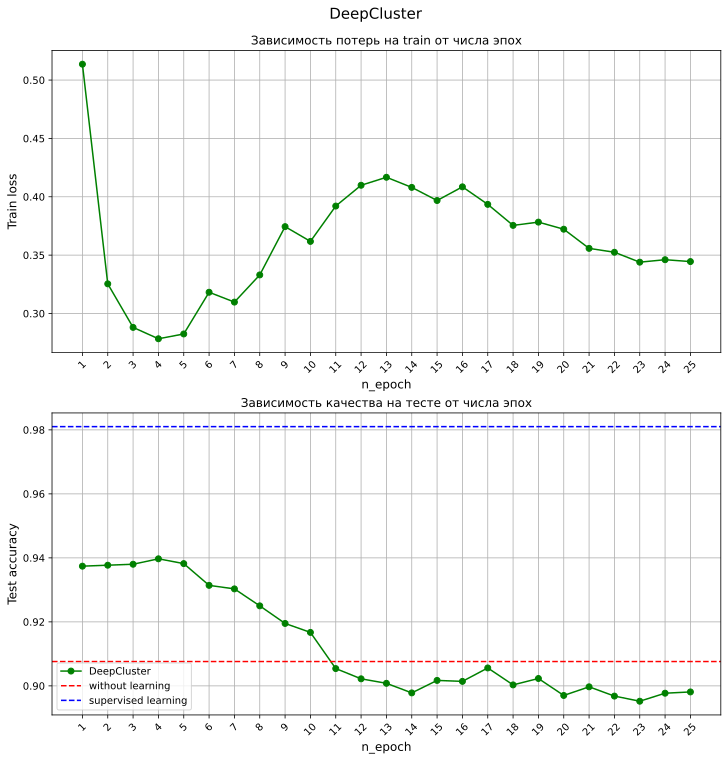

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
plt.suptitle('DeepCluster', fontsize=15, y=0.93)
n_epoch = list(range(1, 26))

plt.subplot(2, 1, 1)
plt.title('Зависимость потерь на train от числа эпох')
plt.xlabel('n_epoch', fontsize=12)
plt.ylabel('Train loss', fontsize=12)
plt.xticks(n_epoch, rotation=45)
plt.plot(n_epoch, loss_tr, marker='o', color='green')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Зависимость качества на тесте от числа эпох')
plt.xlabel('n_epoch', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.xticks(n_epoch, rotation=45)
plt.plot(n_epoch, acc_test, marker='o', color='green', label='DeepCluster')
plt.axhline(y=min_acc, color='red', linestyle='--', label='without learning')
plt.axhline(y=max_acc, color='blue', linestyle='--', label='supervised learning')
plt.legend()
plt.grid()

plt.show()

Видим, что потери на трейне достаточно быстро достигают минимума и дальше растут. Возможно, это связано с простотой датасета и особенностями самообучения. Хорошие результаты достигнуты при рассмотрении 4 эпох. При большом числе эпох результаты на тесте получаются даже хуже, чем для модели со случайными весами...

Рассмотрим также различные соотношения разбиения выборки на две части. Для этого будем менять размер части с размеченными данными от 1000 до 60000 с шагом 1000. Рассматривается четыре эпохи.

In [ ]:
all_size = 60000

supervised_size = list(range(1000, 45000, 1000))

In [ ]:
loss_train, accuracy_test = [], []
for x in supervised_size:
  unsupervised_pretrain, supervised_train = torch.utils.data.random_split(mnist_train, [all_size - x, x])
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  train_loader_unsupervised = torch.utils.data.DataLoader(unsupervised_pretrain, batch_size=64,
                                             shuffle=False)

  train_loader_supervised = torch.utils.data.DataLoader(supervised_train, batch_size=64,
                                             shuffle=False)
  model_DC = CNN()
  model_DC = model_DC.to(device)
  optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.05,
        momentum=0.9,
        weight_decay=10**(-5)
    )
  loss_tr, _ = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=4, k=10, optimizer=optimizer, test=False)
  loss_train.append(loss_tr[-1])
  accuracy_test.append(linear_model(model_DC, train_loader_supervised, test_loader))

Epoch:  0
Loss 0.5089381
Epoch:  1
Loss 0.33344153
Epoch:  2
Loss 0.29729566
Epoch:  3
Loss 0.2937515
Test Accuracy:  0.9206
Epoch:  0
Loss 0.5039498
Epoch:  1
Loss 0.30085415
Epoch:  2
Loss 0.2759575
Epoch:  3
Loss 0.27584583
Test Accuracy:  0.9217
Epoch:  0
Loss 0.51837766
Epoch:  1
Loss 0.32852784
Epoch:  2
Loss 0.31678832
Epoch:  3
Loss 0.32792264
Test Accuracy:  0.9294
Epoch:  0
Loss 0.5172372
Epoch:  1
Loss 0.32196578
Epoch:  2
Loss 0.29752183
Epoch:  3
Loss 0.27569833
Test Accuracy:  0.9324
Epoch:  0
Loss 0.5022246
Epoch:  1
Loss 0.30575648
Epoch:  2
Loss 0.28686354
Epoch:  3
Loss 0.2930115
Test Accuracy:  0.9305
Epoch:  0
Loss 0.5002925
Epoch:  1
Loss 0.31836578
Epoch:  2
Loss 0.29770747
Epoch:  3
Loss 0.29427958
Test Accuracy:  0.9343
Epoch:  0
Loss 0.5077479
Epoch:  1
Loss 0.312906
Epoch:  2
Loss 0.32208303
Epoch:  3
Loss 0.32213193
Test Accuracy:  0.9329
Epoch:  0
Loss 0.50491774
Epoch:  1
Loss 0.31768543
Epoch:  2
Loss 0.28672907
Epoch:  3
Loss 0.27640387
Test Accuracy:  0.

In [ ]:
supervised_size_2 = list(range(45000, 60000, 1000))
for x in supervised_size_2:
  unsupervised_pretrain, supervised_train = torch.utils.data.random_split(mnist_train, [all_size - x, x])
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  train_loader_unsupervised = torch.utils.data.DataLoader(unsupervised_pretrain, batch_size=64,
                                             shuffle=False)

  train_loader_supervised = torch.utils.data.DataLoader(supervised_train, batch_size=64,
                                             shuffle=False)
  model_DC = CNN()
  model_DC = model_DC.to(device)
  optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.05,
        momentum=0.9,
        weight_decay=10**(-5)
    )
  loss_tr, _ = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=4, k=10, optimizer=optimizer, test=False)
  loss_train.append(loss_tr[-1])
  accuracy_test.append(linear_model(model_DC, train_loader_supervised, test_loader))

Epoch:  0
Loss 0.741225
Epoch:  1
Loss 0.42376214
Epoch:  2
Loss 0.40383437
Epoch:  3
Loss 0.39518058
Test Accuracy:  0.9367
Epoch:  0
Loss 0.7823668
Epoch:  1
Loss 0.44257405
Epoch:  2
Loss 0.39171705
Epoch:  3
Loss 0.34727266
Test Accuracy:  0.9467
Epoch:  0
Loss 0.78163743
Epoch:  1
Loss 0.43026444
Epoch:  2
Loss 0.37645477
Epoch:  3
Loss 0.38168982
Test Accuracy:  0.9492
Epoch:  0
Loss 0.8078119
Epoch:  1
Loss 0.4341696
Epoch:  2
Loss 0.43834984
Epoch:  3
Loss 0.39048824
Test Accuracy:  0.9415
Epoch:  0
Loss 0.8558407
Epoch:  1
Loss 0.4534838
Epoch:  2
Loss 0.40091783
Epoch:  3
Loss 0.34461033
Test Accuracy:  0.946
Epoch:  0
Loss 0.8937712
Epoch:  1
Loss 0.4457807
Epoch:  2
Loss 0.40654263
Epoch:  3
Loss 0.40901792
Test Accuracy:  0.9387
Epoch:  0
Loss 0.88779134
Epoch:  1
Loss 0.46092227
Epoch:  2
Loss 0.38911965
Epoch:  3
Loss 0.3939313
Test Accuracy:  0.9484
Epoch:  0
Loss 1.0228314
Epoch:  1
Loss 0.47794643
Epoch:  2
Loss 0.4311691
Epoch:  3
Loss 0.4381558
Test Accuracy:  0.944

In [ ]:
supervised_size = supervised_size + supervised_size_2

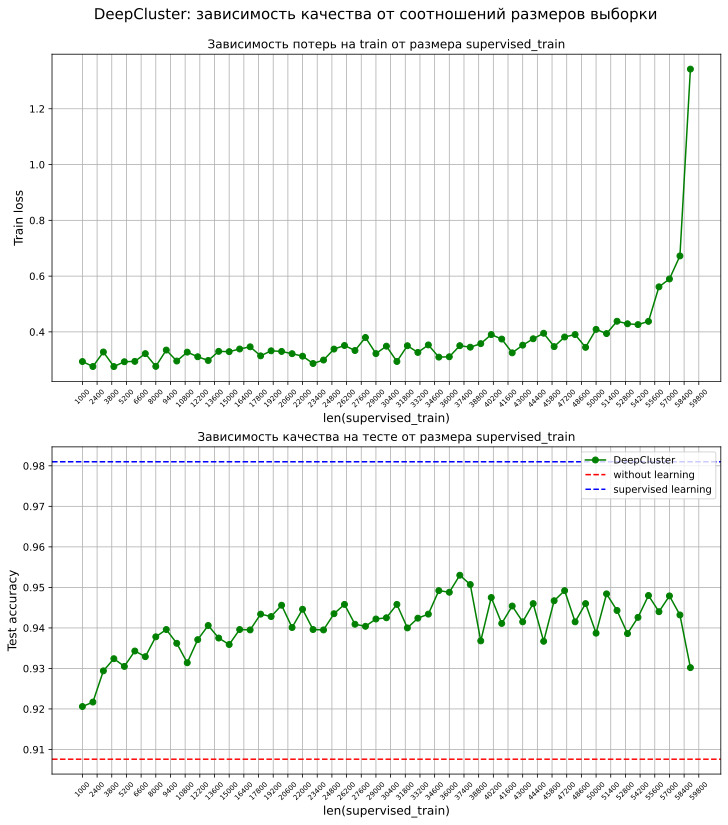

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,13))
plt.suptitle('DeepCluster: зависимость качества от соотношений размеров выборки', fontsize=15, y=0.93)

plt.subplot(2, 1, 1)
plt.title('Зависимость потерь на train от размера supervised_train')
plt.xlabel('len(supervised_train)', fontsize=12)
plt.ylabel('Train loss', fontsize=12)
plt.xticks(list(range(1000, 60000, 1400)), rotation=45, fontsize=7)
plt.plot(supervised_size, loss_train, marker='o', color='green')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Зависимость качества на тесте от размера supervised_train')
plt.xlabel('len(supervised_train)', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.xticks(list(range(1000, 60000, 1400)), rotation=45, fontsize=7)
plt.plot(supervised_size, accuracy_test, marker='o', color='green', label='DeepCluster')
plt.axhline(y=min_acc, color='red', linestyle='--', label='without learning')
plt.axhline(y=max_acc, color='blue', linestyle='--', label='supervised learning')
plt.legend()
plt.grid()

plt.show()

При слишком малом размере выборки, выделенной для самообучения, качество резко падает (на трейне). При этом достаточно хорошие результаты получаются, если выборка разбита примерно пополам. Но так как подбирать параметры по тестовой выборке не очень хорошо, оставим разбиение таким, какое оно есть, к тому же, при исходном разбиении потери на трейне близки к минимальным. И в реальной задаче выбирать, какие данные размеченные, а какие нет, возможности нет, обычно размеченных данных намного меньше.

Визуализация. Рассмотрим, как DeepCluster разбивает картинки по группам.

In [ ]:
model_DC = CNN()
model_DC = model_DC.to(device)
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.05,
        momentum=0.9,
        weight_decay=10**(-5)
    )
loss_tr, acc_test, train_dataset, labels = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=15, k=10, optimizer=optimizer, test=False, train_ds=True)

Epoch:  0
Loss 0.5889127
Epoch:  1
Loss 0.32855204
Epoch:  2
Loss 0.30094263
Epoch:  3
Loss 0.29466674
Epoch:  4
Loss 0.3045607
Epoch:  5
Loss 0.30905962
Epoch:  6
Loss 0.3008252
Epoch:  7
Loss 0.3084461
Epoch:  8
Loss 0.32060754
Epoch:  9
Loss 0.31510288
Epoch:  10
Loss 0.31406996
Epoch:  11
Loss 0.30272406
Epoch:  12
Loss 0.31180835
Epoch:  13
Loss 0.33071834
Epoch:  14
Loss 0.30740166


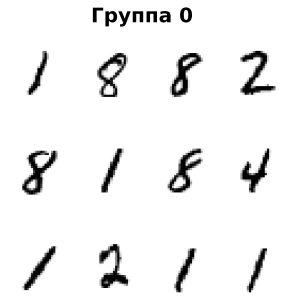

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(5,5))
idx = np.where(labels == 0)[0]
fig.suptitle('Группа 0', y=0.95,
             fontweight = 'bold',
             fontsize = 20)
for i in range(1, 13):
  plt.subplot(3, 4, i)
  # plt.title(labels[i], color='r', fontweight = 'bold')
  plt.imshow(train_dataset[idx[i]][0].reshape(28, 28), cmap="Greys")
  plt.axis("off")
plt.show()

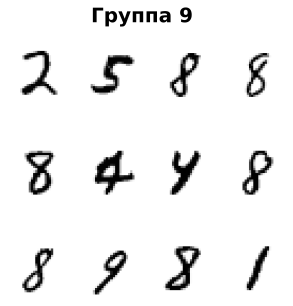

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(5,5))
idx = np.where(labels == 9)[0]
fig.suptitle('Группа 9', y=0.95,
             fontweight = 'bold',
             fontsize = 20)
for i in range(1, 13):
  plt.subplot(3, 4, i)
  # plt.title(labels[i], color='r', fontweight = 'bold')
  plt.imshow(train_dataset[idx[i]][0].reshape(28, 28), cmap="Greys")
  plt.axis("off")
plt.show()

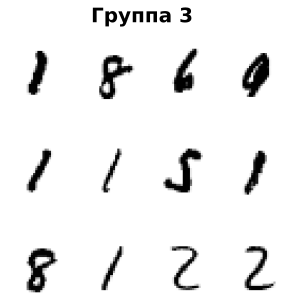

In [ ]:
fig, ax = plt.subplots(3, 4, figsize=(5,5))
idx = np.where(labels == 3)[0]
fig.suptitle('Группа 3', y=0.95,
             fontweight = 'bold',
             fontsize = 20)
for i in range(1, 13):
  plt.subplot(3, 4, i)
  # plt.title(labels[i], color='r', fontweight = 'bold')
  plt.imshow(train_dataset[idx[i]][0].reshape(28, 28), cmap="Greys")
  plt.axis("off")
plt.show()

Интуитивно казалось, что группы должны соответствовать одной и той же цифре... Скорее всего, именно поэтому хорошие результаты на тесте достигаются, если делить выборку примерно пополам. 

Рассмотрим далее перекластеризацию – на вход в DeepCluster будем подавать большее число классов, чем есть на самом деле. И посмотрим, как это влияет на качество и потери.

In [ ]:
k = list(range(10, 110, 3))

In [ ]:
loss_train, accuracy_test = [], []
for x in k:
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  model_DC = CNN()
  model_DC = model_DC.to(device)
  optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.05,
        momentum=0.9,
        weight_decay=10**(-5)
    )
  loss_tr, _ = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=4, k=x, optimizer=optimizer, test=False)
  loss_train.append(loss_tr[-1])
  accuracy_test.append(linear_model(model_DC, train_loader_supervised, test_loader))

Epoch:  0
Loss 0.51573616
Epoch:  1
Loss 0.33233434
Epoch:  2
Loss 0.30406302
Epoch:  3
Loss 0.29832542
Test Accuracy:  0.9344
Epoch:  0
Loss 0.56749445
Epoch:  1
Loss 0.35449216
Epoch:  2
Loss 0.34537408
Epoch:  3
Loss 0.35307148
Test Accuracy:  0.9388
Epoch:  0
Loss 0.61979115
Epoch:  1
Loss 0.37847176
Epoch:  2
Loss 0.36046815
Epoch:  3
Loss 0.37202013
Test Accuracy:  0.9372
Epoch:  0
Loss 0.6773634
Epoch:  1
Loss 0.3975985
Epoch:  2
Loss 0.39051375
Epoch:  3
Loss 0.37865603
Test Accuracy:  0.9427
Epoch:  0
Loss 0.7129401
Epoch:  1
Loss 0.45215383
Epoch:  2
Loss 0.41206512
Epoch:  3
Loss 0.41862184
Test Accuracy:  0.9404
Epoch:  0
Loss 0.74426126
Epoch:  1
Loss 0.4466527
Epoch:  2
Loss 0.41743216
Epoch:  3
Loss 0.40790528
Test Accuracy:  0.951
Epoch:  0
Loss 0.8150532
Epoch:  1
Loss 0.47918287
Epoch:  2
Loss 0.44618806
Epoch:  3
Loss 0.449926
Test Accuracy:  0.9461
Epoch:  0
Loss 0.8445769
Epoch:  1
Loss 0.4960543
Epoch:  2
Loss 0.47169146
Epoch:  3
Loss 0.4523075
Test Accuracy:  0.

In [ ]:
k_2 = list(range(112, 230, 3))
for x in k_2:
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  model_DC = CNN()
  model_DC = model_DC.to(device)
  optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.05,
        momentum=0.9,
        weight_decay=10**(-5)
    )
  loss_tr, _ = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=4, k=x, optimizer=optimizer, test=False)
  loss_train.append(loss_tr[-1])
  accuracy_test.append(linear_model(model_DC, train_loader_supervised, test_loader))

Epoch:  0
Loss 1.645214
Epoch:  1
Loss 1.0087013
Epoch:  2
Loss 0.9491113
Epoch:  3
Loss 0.9222402
Test Accuracy:  0.9473
Epoch:  0
Loss 1.6857073
Epoch:  1
Loss 1.0380988
Epoch:  2
Loss 0.99301517
Epoch:  3
Loss 0.945381
Test Accuracy:  0.9423
Epoch:  0
Loss 1.6842858
Epoch:  1
Loss 1.0654353
Epoch:  2
Loss 0.9781035
Epoch:  3
Loss 0.9330232
Test Accuracy:  0.949
Epoch:  0
Loss 1.7216609
Epoch:  1
Loss 1.0468512
Epoch:  2
Loss 0.9796012
Epoch:  3
Loss 0.9481749
Test Accuracy:  0.9491
Epoch:  0
Loss 1.739072
Epoch:  1
Loss 1.0953404
Epoch:  2
Loss 1.0273718
Epoch:  3
Loss 0.99180824
Test Accuracy:  0.9499
Epoch:  0
Loss 1.7419164
Epoch:  1
Loss 1.0740826
Epoch:  2
Loss 0.9981681
Epoch:  3
Loss 0.97760695
Test Accuracy:  0.9512
Epoch:  0
Loss 1.7666657
Epoch:  1
Loss 1.097112
Epoch:  2
Loss 0.9905231
Epoch:  3
Loss 0.97722864
Test Accuracy:  0.9492
Epoch:  0
Loss 1.790646
Epoch:  1
Loss 1.0986925
Epoch:  2
Loss 1.0220175
Epoch:  3
Loss 0.98253834
Test Accuracy:  0.9508
Epoch:  0
Loss 1.

In [ ]:
k = k + k_2

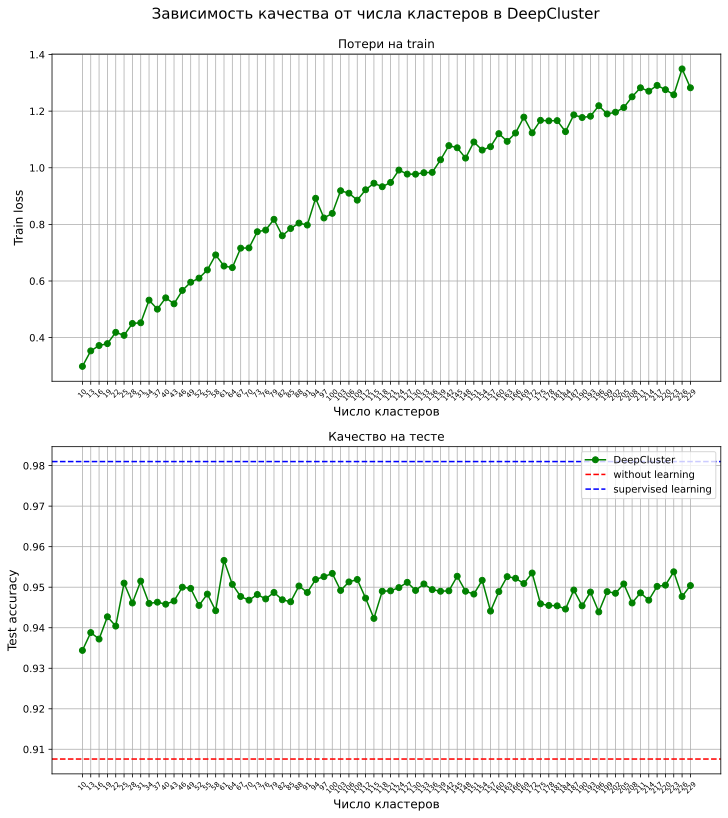

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12,13))
plt.suptitle('Зависимость качества от числа кластеров в DeepCluster', fontsize=15, y=0.93)

plt.subplot(2, 1, 1)
plt.title('Потери на train')
plt.xlabel('Число кластеров', fontsize=12)
plt.ylabel('Train loss', fontsize=12)
plt.xticks(k, rotation=45, fontsize=7)
plt.plot(k, loss_train, marker='o', color='green')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Качество на тесте')
plt.xlabel('Число кластеров', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.xticks(k, rotation=45, fontsize=7)
plt.plot(k, accuracy_test, marker='o', color='green', label='DeepCluster')
plt.axhline(y=min_acc, color='red', linestyle='--', label='without learning')
plt.axhline(y=max_acc, color='blue', linestyle='--', label='supervised learning')
plt.legend()
plt.grid()

plt.show()

С увеличением числа классов потери на трейне естественным образом линейно растут. На тесте же видно, что при числе классов, большем хотя бы в два раза, чем есть на самом деле (10), качество значительно вырастает. Что подтверждает идею о том, что перекластеризация помогает добиться более хороших результатов.

Теперь рассмотрим различные варианты оптимизаторов. До этого использовался оптимизатор как в оригинальном коде. Попробуем подобрать для него параметры и рассмотреть другой оптимизатор.

torch.optim.SGD – оптимизатор, который реализует стохастический градиентный спуск (опционально с импульсом). Рассмотрим сначала перебор шага.

In [ ]:
import time
lr = np.logspace(-3, 0, 20)
loss_train, accuracy_test, t = [], [], []
for x in lr:
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  model_DC = CNN()
  model_DC = model_DC.to(device)
  optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=x,
        momentum=0.9,
        weight_decay=10**(-5)
    )
  start = time.time()
  loss_tr, _ = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=4, k=60, optimizer=optimizer, test=False)
  loss_train.append(loss_tr[-1])
  accuracy_test.append(linear_model(model_DC, train_loader_supervised, test_loader))
  t.append(time.time() - start)

Epoch:  0
Loss 3.1048775
Epoch:  1
Loss 1.2318757
Epoch:  2
Loss 0.97191715
Epoch:  3
Loss 0.86647147
Test Accuracy:  0.9401
Epoch:  0
Loss 2.8262937
Epoch:  1
Loss 1.0700881
Epoch:  2
Loss 0.88941914
Epoch:  3
Loss 0.8090379
Test Accuracy:  0.9413
Epoch:  0
Loss 2.4899728
Epoch:  1
Loss 0.93890464
Epoch:  2
Loss 0.79654276
Epoch:  3
Loss 0.74877065
Test Accuracy:  0.9445
Epoch:  0
Loss 2.234252
Epoch:  1
Loss 0.86813736
Epoch:  2
Loss 0.76083493
Epoch:  3
Loss 0.7299724
Test Accuracy:  0.9515
Epoch:  0
Loss 2.0326133
Epoch:  1
Loss 0.819588
Epoch:  2
Loss 0.7427374
Epoch:  3
Loss 0.67947024
Test Accuracy:  0.9534
Epoch:  0
Loss 1.8169711
Epoch:  1
Loss 0.76519865
Epoch:  2
Loss 0.69249326
Epoch:  3
Loss 0.649588
Test Accuracy:  0.9549
Epoch:  0
Loss 1.6277311
Epoch:  1
Loss 0.7669419
Epoch:  2
Loss 0.7085217
Epoch:  3
Loss 0.6917794
Test Accuracy:  0.952
Epoch:  0
Loss 1.4938688
Epoch:  1
Loss 0.7461528
Epoch:  2
Loss 0.6769063
Epoch:  3
Loss 0.62856793
Test Accuracy:  0.9536
Epoch:  

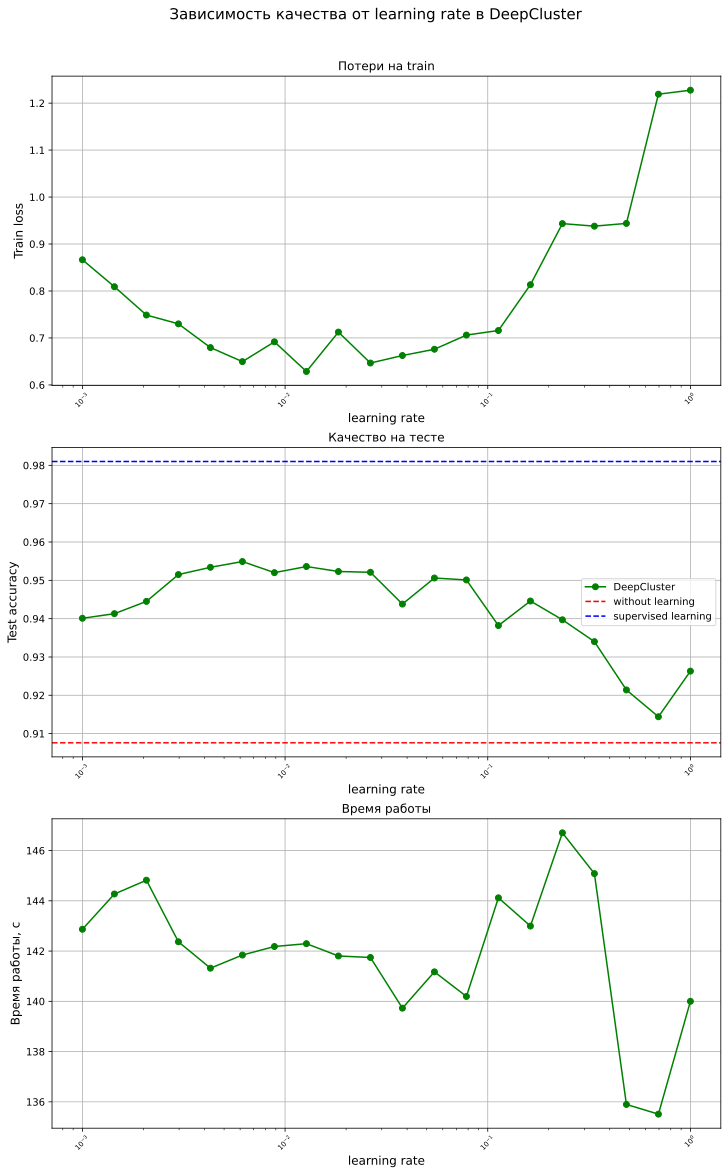

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12,19))
plt.suptitle('Зависимость качества от learning rate в DeepCluster', fontsize=15, y=0.93)

plt.subplot(3, 1, 1)
plt.title('Потери на train')
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('Train loss', fontsize=12)
plt.xticks(lr, rotation=45, fontsize=7)
plt.plot(lr, loss_train, marker='o', color='green')
plt.xscale('log')
plt.grid()

plt.subplot(3, 1, 2)
plt.title('Качество на тесте')
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.xticks(lr, rotation=45, fontsize=7)
plt.plot(lr, accuracy_test, marker='o', color='green', label='DeepCluster')
plt.axhline(y=min_acc, color='red', linestyle='--', label='without learning')
plt.axhline(y=max_acc, color='blue', linestyle='--', label='supervised learning')
plt.xscale('log')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.title('Время работы')
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('Время работы, с', fontsize=12)
plt.xticks(lr, rotation=45, fontsize=7)
plt.plot(lr, t, marker='o', color='green', label='DeepCluster')
plt.xscale('log')
plt.grid()

plt.show()

Рассматриваем learning rate 0.013 как показавший один из минимумов на трейне и хороший результат на тесте. Подберем momentum.

In [ ]:
loss_train, accuracy_test, t = [], [], []
m = np.linspace(0.1, .9, 9)
for x in m:
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  model_DC = CNN()
  model_DC = model_DC.to(device)
  optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.013,
        momentum=x,
        weight_decay=10**(-5)
    )
  start = time.time()
  loss_tr, _ = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=4, k=60, optimizer=optimizer, test=False)
  loss_train.append(loss_tr[-1])
  accuracy_test.append(linear_model(model_DC, train_loader_supervised, test_loader))
  t.append(time.time() - start)

Epoch:  0
Loss 2.7210195
Epoch:  1
Loss 1.0620978
Epoch:  2
Loss 0.8628541
Epoch:  3
Loss 0.80846894
Test Accuracy:  0.9447
Epoch:  0
Loss 2.6431692
Epoch:  1
Loss 1.027742
Epoch:  2
Loss 0.851924
Epoch:  3
Loss 0.7691201
Test Accuracy:  0.9497
Epoch:  0
Loss 2.5310736
Epoch:  1
Loss 0.9608732
Epoch:  2
Loss 0.8174318
Epoch:  3
Loss 0.7385795
Test Accuracy:  0.947
Epoch:  0
Loss 2.4258554
Epoch:  1
Loss 0.9502307
Epoch:  2
Loss 0.8088038
Epoch:  3
Loss 0.741429
Test Accuracy:  0.9475
Epoch:  0
Loss 2.3049026
Epoch:  1
Loss 0.90201503
Epoch:  2
Loss 0.7927097
Epoch:  3
Loss 0.72685695
Test Accuracy:  0.9482
Epoch:  0
Loss 2.1031337
Epoch:  1
Loss 0.85297436
Epoch:  2
Loss 0.750184
Epoch:  3
Loss 0.68434435
Test Accuracy:  0.9547
Epoch:  0
Loss 1.9231986
Epoch:  1
Loss 0.8204097
Epoch:  2
Loss 0.69716233
Epoch:  3
Loss 0.6548928
Test Accuracy:  0.9533
Epoch:  0
Loss 1.7448331
Epoch:  1
Loss 0.7801382
Epoch:  2
Loss 0.6972157
Epoch:  3
Loss 0.6470213
Test Accuracy:  0.9527
Epoch:  0
Loss 

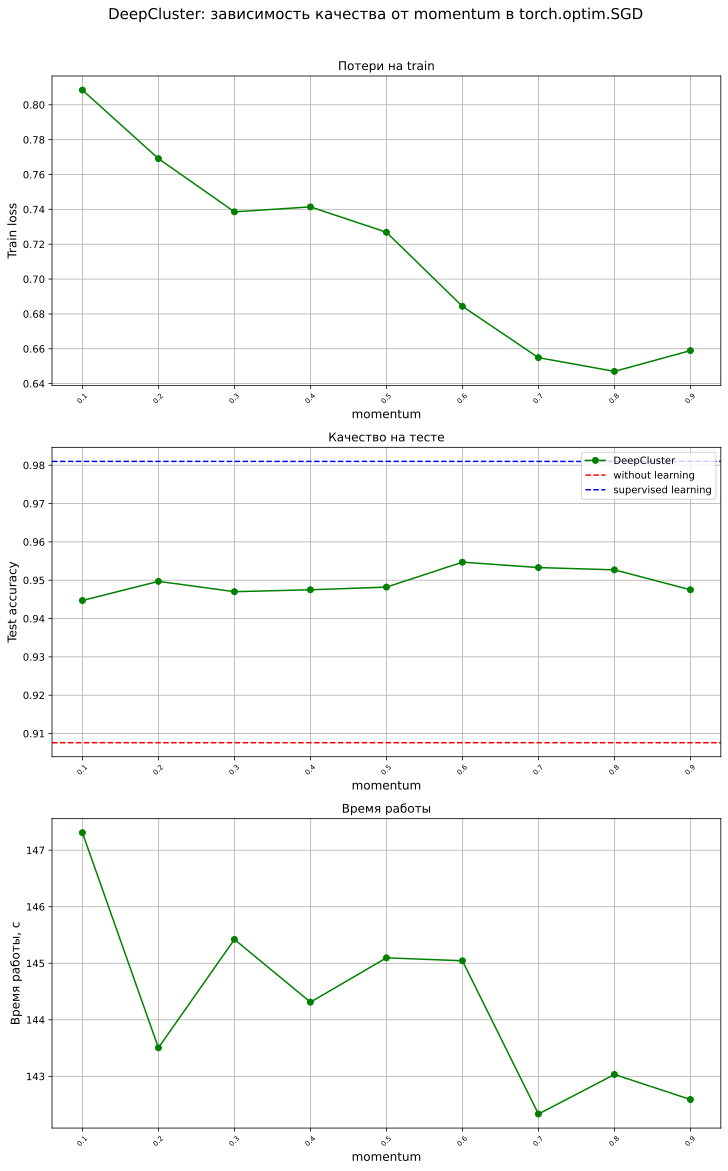

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(12,19))
plt.suptitle('DeepCluster: зависимость качества от momentum в torch.optim.SGD', fontsize=15, y=0.93)

plt.subplot(3, 1, 1)
plt.title('Потери на train')
plt.xlabel('momentum', fontsize=12)
plt.ylabel('Train loss', fontsize=12)
plt.xticks(m, rotation=45, fontsize=7)
plt.plot(m, loss_train, marker='o', color='green')
plt.grid()

plt.subplot(3, 1, 2)
plt.title('Качество на тесте')
plt.xlabel('momentum', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.xticks(m, rotation=45, fontsize=7)
plt.plot(m, accuracy_test, marker='o', color='green', label='DeepCluster')
plt.axhline(y=min_acc, color='red', linestyle='--', label='without learning')
plt.axhline(y=max_acc, color='blue', linestyle='--', label='supervised learning')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.title('Время работы')
plt.xlabel('momentum', fontsize=12)
plt.ylabel('Время работы, с', fontsize=12)
plt.xticks(m, rotation=45, fontsize=7)
plt.plot(m, t, marker='o', color='green', label='DeepCluster')
plt.grid()

plt.show()

Хороший результат получается при momentum=0.8. Конечно, 0.6 лучше на тесте, но подбирать параметры по тесту нельзя и тут просто проводится сравнение.

Рассмотрим также torch.optim.Adam и подберем для него learning rate.

torch.optim.Adam – оптимизатор, который реализует алгоритм Адама.

In [17]:
lr = np.logspace(-3, 0, 10)
loss_train, accuracy_test, t = [], [], []
for x in lr:
  torch.manual_seed(0)
  torch.cuda.manual_seed(0)
  model_DC = CNN()
  model_DC = model_DC.to(device)
  optimizer = torch.optim.Adam(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=x,
        weight_decay=10**(-5)
    )
  start = time.time()
  loss_tr, _ = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=4, k=60, optimizer=optimizer, test=False)
  loss_train.append(loss_tr[-1])
  accuracy_test.append(linear_model(model_DC, train_loader_supervised, test_loader))
  t.append(time.time() - start)

Epoch:  0
Loss 1.2169287
Epoch:  1
Loss 0.760306
Epoch:  2
Loss 0.72627383
Epoch:  3
Loss 0.72820866
Test Accuracy:  0.95
Epoch:  0
Loss 1.1065706
Epoch:  1
Loss 0.7781815
Epoch:  2
Loss 0.766229
Epoch:  3
Loss 0.78819203
Test Accuracy:  0.9484
Epoch:  0
Loss 1.0025833
Epoch:  1
Loss 0.7744543
Epoch:  2
Loss 0.7693692
Epoch:  3
Loss 0.7574698
Test Accuracy:  0.9415
Epoch:  0
Loss 1.0161946
Epoch:  1
Loss 0.94018143
Epoch:  2
Loss 0.9467297
Epoch:  3
Loss 0.9362795
Test Accuracy:  0.9424
Epoch:  0
Loss 0.97960615
Epoch:  1
Loss 0.885629
Epoch:  2
Loss 0.8438748
Epoch:  3
Loss 0.83711684
Test Accuracy:  0.9367
Epoch:  0
Loss 1.1951108
Epoch:  1
Loss 1.1648831
Epoch:  2
Loss 1.1183449
Epoch:  3
Loss 1.0886741
Test Accuracy:  0.9317
Epoch:  0
Loss 1.4761554
Epoch:  1
Loss 1.3847888
Epoch:  2
Loss 1.2951722
Epoch:  3
Loss 1.3267468
Test Accuracy:  0.9114
Epoch:  0
Loss 1.7860628
Epoch:  1
Loss 1.567042
Epoch:  2
Loss 1.592898
Epoch:  3
Loss 1.6025388
Test Accuracy:  0.8941
Epoch:  0
Loss 4.

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Test Accuracy:  0.5972


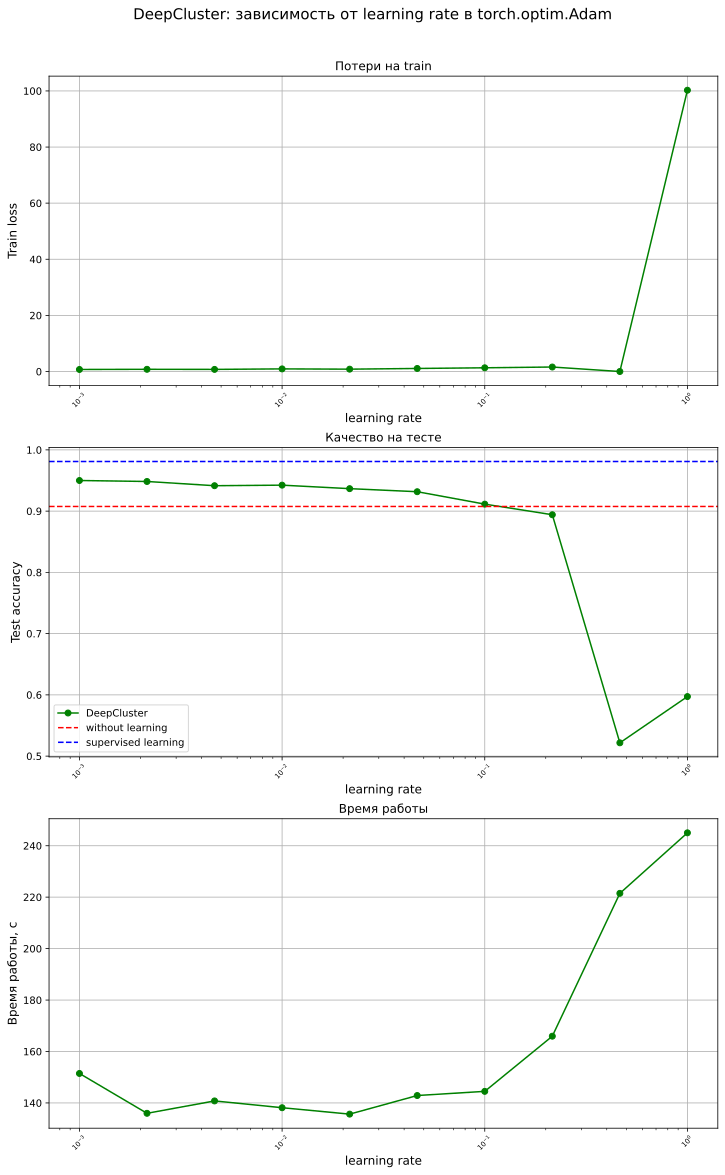

In [19]:
fig, ax = plt.subplots(3, 1, figsize=(12,19))
plt.suptitle('DeepCluster: зависимость от learning rate в torch.optim.Adam', fontsize=15, y=0.93)

plt.subplot(3, 1, 1)
plt.title('Потери на train')
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('Train loss', fontsize=12)
plt.xticks(lr, rotation=45, fontsize=7)
plt.plot(lr, loss_train, marker='o', color='green')
plt.xscale('log')
plt.grid()

plt.subplot(3, 1, 2)
plt.title('Качество на тесте')
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.xticks(lr, rotation=45, fontsize=7)
plt.plot(lr, accuracy_test, marker='o', color='green', label='DeepCluster')
plt.axhline(y=min_acc, color='red', linestyle='--', label='without learning')
plt.axhline(y=max_acc, color='blue', linestyle='--', label='supervised learning')
plt.xscale('log')
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.title('Время работы')
plt.xlabel('learning rate', fontsize=12)
plt.ylabel('Время работы, с', fontsize=12)
plt.xticks(lr, rotation=45, fontsize=7)
plt.plot(lr, t, marker='o', color='green', label='DeepCluster')
plt.xscale('log')
plt.grid()

plt.show()

Даже при самых хороших шагах результаты похуже, чем для предыдущего оптимизатора. Большой шаг этому оптимизатору на данном датасете, очевидно, не подходит.

Рассмотрим применение оператора Собеля. Для этого подредактируем исходную сеть.

Оператор Собеля может позволить достичь в данной задаче результатов лучше, так как он применяется для удаления информации о цвете и увеличения контраста аугментация данных

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=10, sobel=True):
      super(CNN, self).__init__()
      self.features = nn.Sequential(
          nn.Conv2d(1, 8, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(8),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(16),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Dropout()
          )
      self.classifier = nn.Sequential(
          nn.Linear(7 * 7 * 16, 64),
          nn.ReLU(),
      )
      self.top_layer = nn.Linear(64, num_classes)
      self._initialize_weights()

      if sobel:
        grayscale = nn.Conv2d(3, 1, kernel_size=1, stride=1, padding=0)
        grayscale.weight.data.fill_(1.0 / 3.0)
        grayscale.bias.data.zero_()
        sobel_filter = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1)
        sobel_filter.weight.data[0, 0].copy_(
            torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        )
        sobel_filter.weight.data[1, 0].copy_(
            torch.FloatTensor([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        )
        sobel_filter.bias.data.zero_()
        self.sobel = nn.Sequential(grayscale, sobel_filter)
        for p in self.sobel.parameters():
            p.requires_grad = False
        else:
            self.sobel = None

  def forward(self, x):
      if self.sobel:
        x = self.sobel(x)
      x = self.features(x)
      x = x.view(x.size(0), -1)
      x = self.classifier(x)
      if self.top_layer:
        x = self.top_layer(x)
      return x

  def _initialize_weights(self):
    for y, m in enumerate(self.modules()):
      if isinstance(m, nn.Conv2d):
          n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
          for i in range(m.out_channels):
              m.weight.data[i].normal_(0, math.sqrt(2. / n))
          if m.bias is not None:
              m.bias.data.zero_()
      elif isinstance(m, nn.BatchNorm2d):
          m.weight.data.fill_(1)
          m.bias.data.zero_()
      elif isinstance(m, nn.Linear):
          m.weight.data.normal_(0, 0.01)
          m.bias.data.zero_()

Рассмотрим применение оператора на "хороших" параметрах оптимизатора и четырех вариантах числа кластеров.

In [25]:
model_DC = CNN()
model_DC = model_DC.to(device)
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.013,
        momentum=0.8,
        weight_decay=10**(-5)
    )
loss_tr_1, acc_test_1 = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=10, k=10, optimizer=optimizer, test=True)

Epoch:  0
Loss 0.652678
Test Accuracy:  0.9258
Epoch:  1
Loss 0.34082443
Test Accuracy:  0.9278
Epoch:  2
Loss 0.35047787
Test Accuracy:  0.9298
Epoch:  3
Loss 0.3154953
Test Accuracy:  0.9326
Epoch:  4
Loss 0.30732995
Test Accuracy:  0.9287
Epoch:  5
Loss 0.30308458
Test Accuracy:  0.9307
Epoch:  6
Loss 0.30351964
Test Accuracy:  0.9309
Epoch:  7
Loss 0.30410522
Test Accuracy:  0.9275
Epoch:  8
Loss 0.29696733
Test Accuracy:  0.927
Epoch:  9
Loss 0.29688862
Test Accuracy:  0.9273


In [26]:
model_DC = CNN()
model_DC = model_DC.to(device)
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.013,
        momentum=0.8,
        weight_decay=10**(-5)
    )
loss_tr_2, acc_test_2 = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=10, k=30, optimizer=optimizer, test=True)

Epoch:  0
Loss 1.2567663
Test Accuracy:  0.9305
Epoch:  1
Loss 0.61754954
Test Accuracy:  0.9351
Epoch:  2
Loss 0.57612014
Test Accuracy:  0.938
Epoch:  3
Loss 0.5788219
Test Accuracy:  0.9369
Epoch:  4
Loss 0.569399
Test Accuracy:  0.9405
Epoch:  5
Loss 0.57568043
Test Accuracy:  0.9415
Epoch:  6
Loss 0.56376743
Test Accuracy:  0.9417
Epoch:  7
Loss 0.55529296
Test Accuracy:  0.9404
Epoch:  8
Loss 0.56835395
Test Accuracy:  0.9412
Epoch:  9
Loss 0.5636834
Test Accuracy:  0.9398


In [27]:
model_DC = CNN()
model_DC = model_DC.to(device)
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.013,
        momentum=0.8,
        weight_decay=10**(-5)
    )
loss_tr_3, acc_test_3 = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=10, k=60, optimizer=optimizer, test=True)

Epoch:  0
Loss 1.7717903
Test Accuracy:  0.947
Epoch:  1
Loss 0.7486291
Test Accuracy:  0.9542
Epoch:  2
Loss 0.70418555
Test Accuracy:  0.9561
Epoch:  3
Loss 0.6622779
Test Accuracy:  0.9574
Epoch:  4
Loss 0.64116734
Test Accuracy:  0.9553
Epoch:  5
Loss 0.62813586
Test Accuracy:  0.9544
Epoch:  6
Loss 0.6162992
Test Accuracy:  0.9569
Epoch:  7
Loss 0.57761985
Test Accuracy:  0.9557
Epoch:  8
Loss 0.5774129
Test Accuracy:  0.9557
Epoch:  9
Loss 0.572595
Test Accuracy:  0.9545


In [28]:
model_DC = CNN()
model_DC = model_DC.to(device)
optimizer = torch.optim.SGD(
        filter(lambda x: x.requires_grad, model_DC.parameters()),
        lr=0.013,
        momentum=0.8,
        weight_decay=10**(-5)
    )
loss_tr_4, acc_test_4 = DeepCluster(model_DC, device, train_loader_unsupervised, epoch=10, k=100, optimizer=optimizer, test=True)

Epoch:  0
Loss 2.3668847
Test Accuracy:  0.9433
Epoch:  1
Loss 1.0233284
Test Accuracy:  0.9481
Epoch:  2
Loss 0.92105716
Test Accuracy:  0.9526
Epoch:  3
Loss 0.84858745
Test Accuracy:  0.9539
Epoch:  4
Loss 0.82973444
Test Accuracy:  0.9511
Epoch:  5
Loss 0.80568784
Test Accuracy:  0.9505
Epoch:  6
Loss 0.8186091
Test Accuracy:  0.95
Epoch:  7
Loss 0.80749387
Test Accuracy:  0.9497
Epoch:  8
Loss 0.8085164
Test Accuracy:  0.9501
Epoch:  9
Loss 0.80838597
Test Accuracy:  0.9469


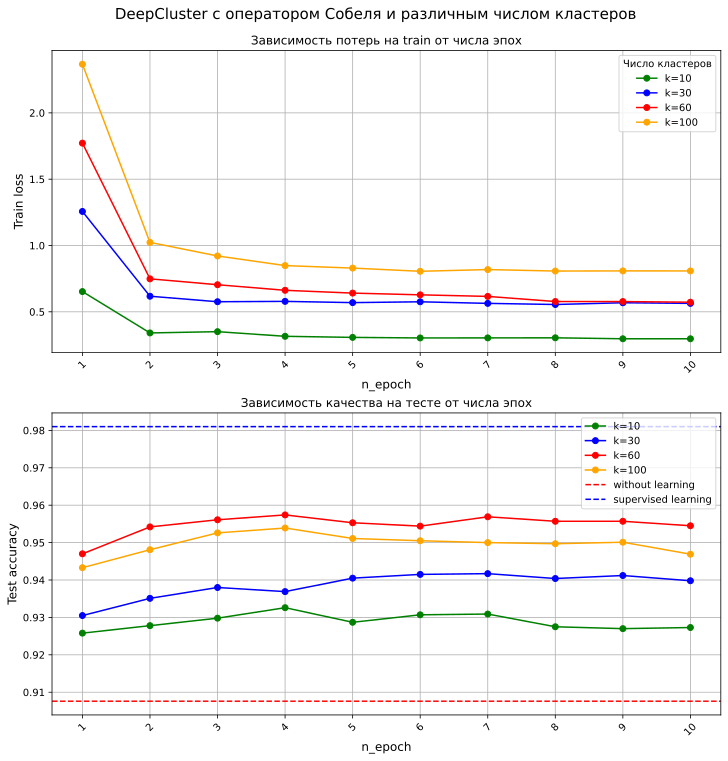

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(12,12))
plt.suptitle('DeepCluster c оператором Собеля и различным числом кластеров', fontsize=15, y=0.93)
n_epoch = list(range(1, 11))

plt.subplot(2, 1, 1)
plt.title('Зависимость потерь на train от числа эпох')
plt.xlabel('n_epoch', fontsize=12)
plt.ylabel('Train loss', fontsize=12)
plt.xticks(n_epoch, rotation=45)
plt.plot(n_epoch, loss_tr_1, marker='o', color='green', label='k=10')
plt.plot(n_epoch, loss_tr_2, marker='o', color='blue', label='k=30')
plt.plot(n_epoch, loss_tr_3, marker='o', color='red', label='k=60')
plt.plot(n_epoch, loss_tr_4, marker='o', color='orange', label='k=100')
plt.legend(title='Число кластеров')
plt.grid()

plt.subplot(2, 1, 2)
plt.title('Зависимость качества на тесте от числа эпох')
plt.xlabel('n_epoch', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.xticks(n_epoch, rotation=45)
plt.plot(n_epoch, acc_test_1, marker='o', color='green', label='k=10')
plt.plot(n_epoch, acc_test_2, marker='o', color='blue', label='k=30')
plt.plot(n_epoch, acc_test_3, marker='o', color='red', label='k=60')
plt.plot(n_epoch, acc_test_4, marker='o', color='orange', label='k=100')
plt.axhline(y=min_acc, color='red', linestyle='--', label='without learning')
plt.axhline(y=max_acc, color='blue', linestyle='--', label='supervised learning')
plt.legend()
plt.grid()

plt.show()

Если сравнить с предыдущими результатами, то можно заметить, что существенно снижаются потери на трейне с первой же эпохи. Качество при этом выросло не так сильно, как ожидалось, но тем не менее оно достаточно хорошее, особенно при k=60. Скорее всего, опять же, это связано с простотой датасета и на более сложных данных получилось бы значительное улучшение.

Полученные результаты: реализован DeepCluster, получены хорошие результаты при его работе, убедились в необходимости перекластеризации для достижения хороших результатов, приведены сравнения с различными параметрами и моделью со случайными весами и обученной на данных с разметкой моделью. Достигнуто качество 0.9574 на тесте.

Источники: 

код https://github.com/facebookresearch/deepcluster

статья https://arxiv.org/abs/1807.05520

и лекция на соответствующую тему